In [1]:
# Set up the environment

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

import acquire, summarize, prepare, wrangle_zillow, features, model

from IPython.display import Image

In [2]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset for exploration
train, validate, test = wrangle_zillow.wrangle_zillow_clustering(zillow)

# Map fips number to county names
train.fips = train.apply(lambda i: wrangle_zillow.add_county_column(i), axis=1)

# Create a dataframe to hold the target variable
target_var = train.logerror

# Exploring the Drivers of the Error in the Zestimate
- ## Presenter: Yongliang Shi
- ## Date: Oct 21 2020

## Goal: to uncover what the drivers of the error in the zestimate are

- ### Step 1: Explore the Target Variable: Logerror
- ### Step 2: Clustering Logerror
- ### Step 3: Modeling and Evalution

# Explore Target Variable - What does logerror look like? 

In [3]:
# Print the descriptive statistics of the target variable logerror
percentiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
train.logerror.describe(percentiles).round(3)

count    31028.000
mean         0.020
std          0.178
min         -4.655
10%         -0.071
20%         -0.035
25%         -0.024
30%         -0.016
40%         -0.004
50%          0.007
60%          0.018
70%          0.031
75%          0.041
80%          0.053
90%          0.105
max          3.395
Name: logerror, dtype: float64

# Explore Target Varibale logerror - What does the number mean? 
- ## logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$
    - ### if logerror = -4.655(min) --> zestimate / sale price = 0.00002
    - ### if logerror = 0.007(50%) --> zestimate / sale price = 1.016
    - ### if logerror = 3.395(max) --> zestimate / sale price = 2483

[Text(0.5, 0, '')]

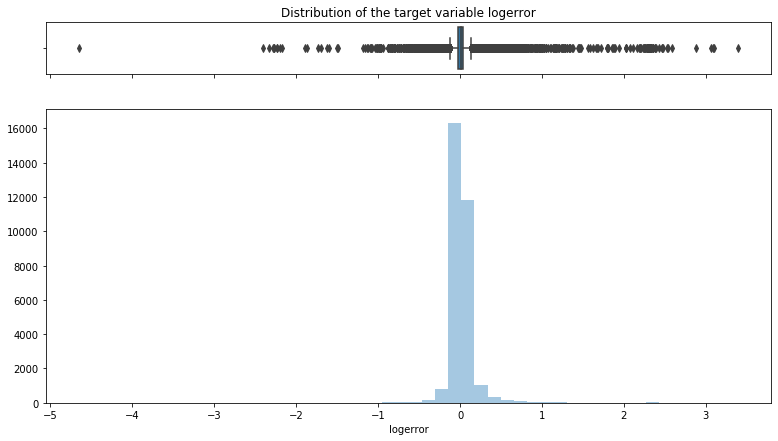

In [4]:
# Visualize the logerror distribution by boxplot and histogram
# Cut the window into 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(13,7),  
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

# Add a graph in each part
sns.boxplot(target_var, ax=ax_box)
sns.distplot(target_var, kde=False, ax=ax_hist)

# Add title
ax_box.set_title('Distribution of the target variable logerror')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

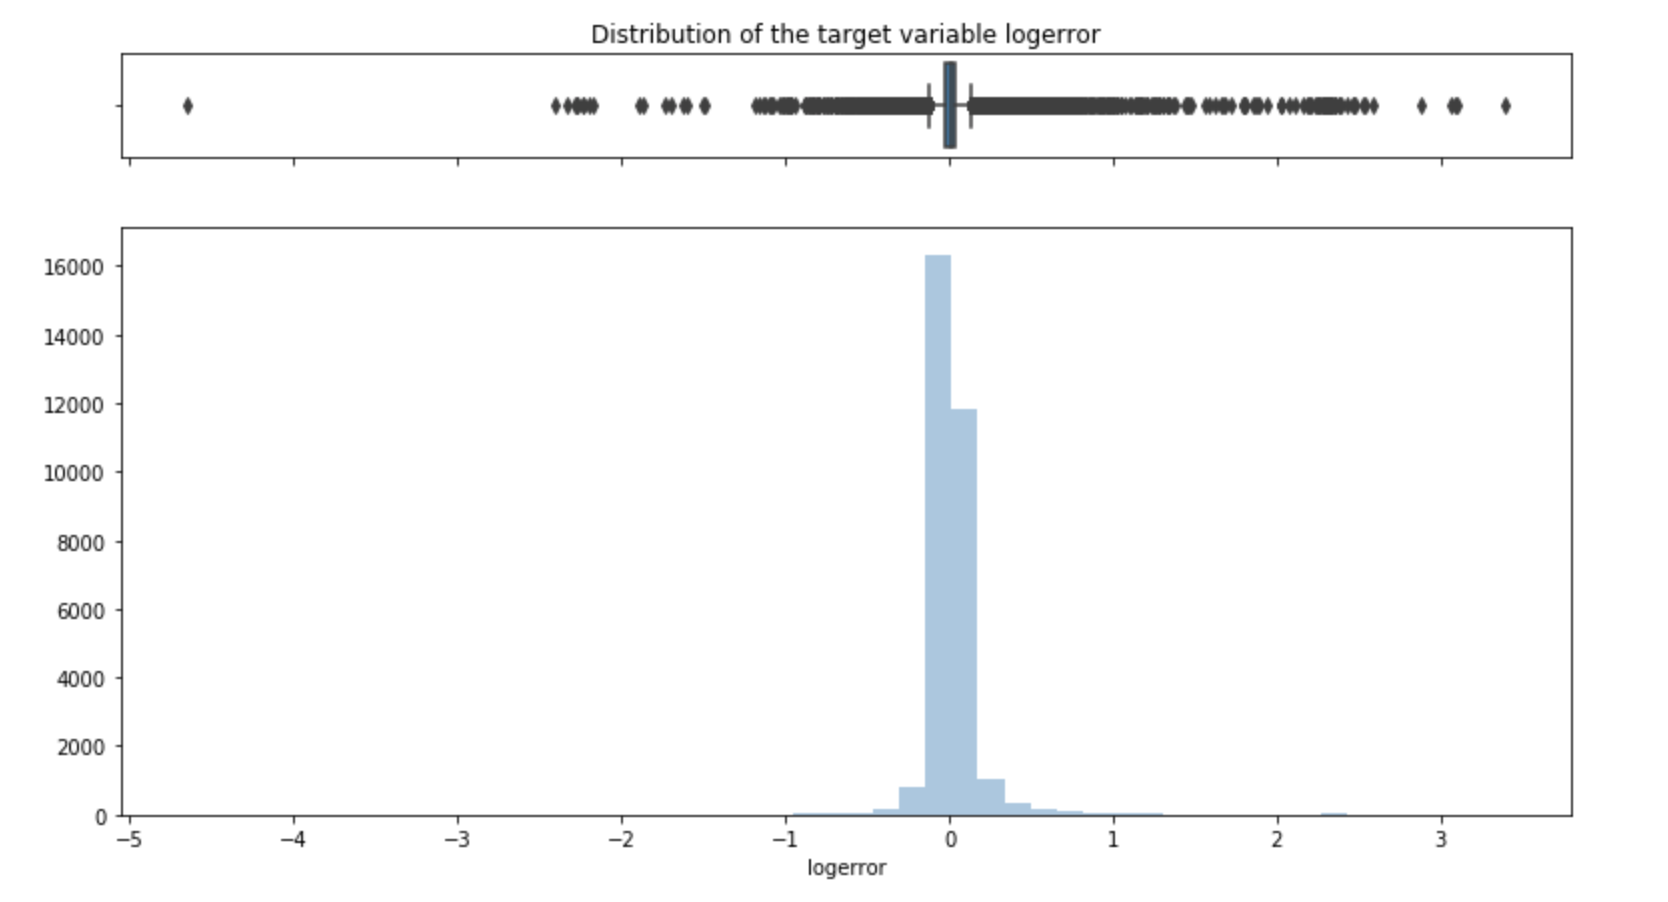

In [5]:
Image(filename = "logerror_dist.png", width = 750, height = 500)

# Explore Target Varibale logerror - What does the number mean? 
- ## logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$
    - ## sale price is not available, but...
    - ## assessed value: taxvaluedollarcnt, which has been modeled in the previous regression project

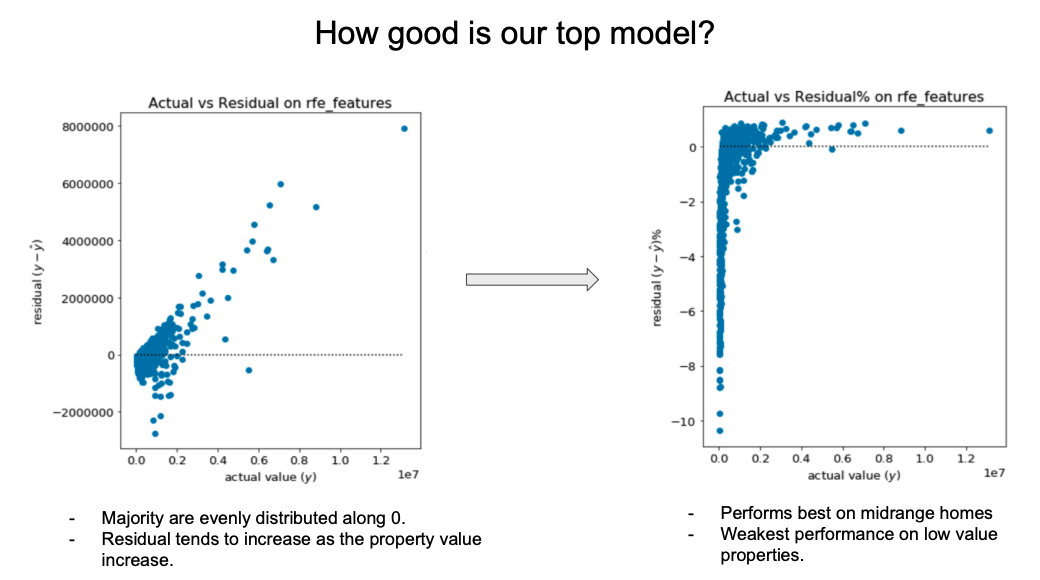

In [6]:
# Load residual analysis from regression project
Image(filename = "regression_model_performance.png", width = 750, height = 500)

## Does the statement below stand true?
### - Our target variable logerror is related to the assessed value? 

Text(0.5, 1.0, 'Distribtion of logerror against log(assessed values)')

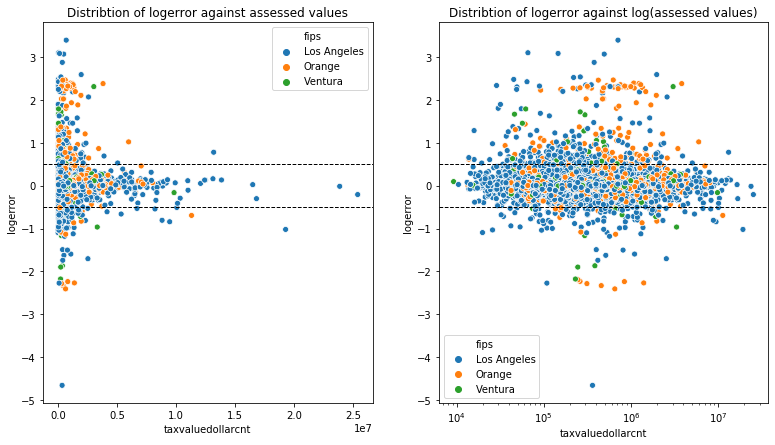

In [7]:
# Plot distribution of logerror again assessed value
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against assessed values')

plt.subplot(122)
ax = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
ax.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against log(assessed values)')

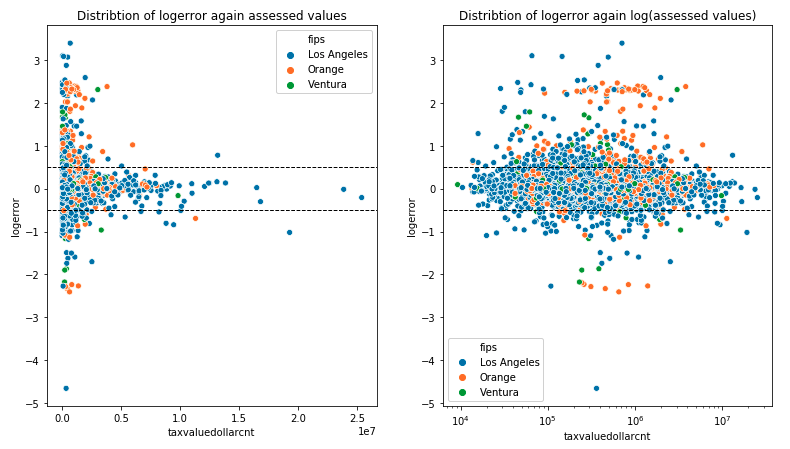

In [8]:
Image(filename = "logerror_taxvalue.png", width = 750, height = 500)

Text(0.5, 1.0, 'Distribution of logerror again finished square feet')

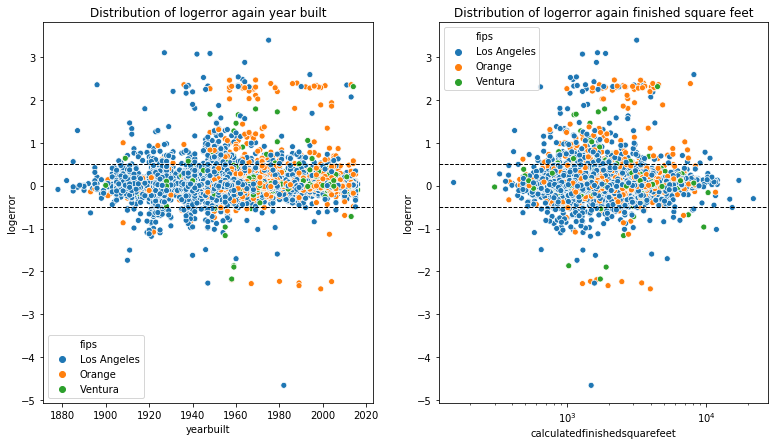

In [9]:
plt.figure(figsize=(13,7))

plt.subplot(121)
ax1 = sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again year built')


plt.subplot(122)
ax2 = sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='fips')
ax2.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again finished square feet')

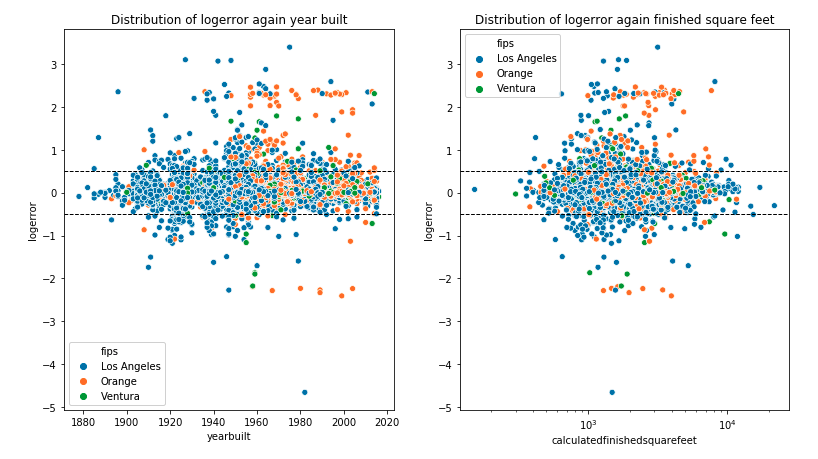

In [10]:
Image(filename = "logerror_year_square.png", width = 750, height = 500)

Text(0.5, 1.0, 'Distribution of logerror again latitude')

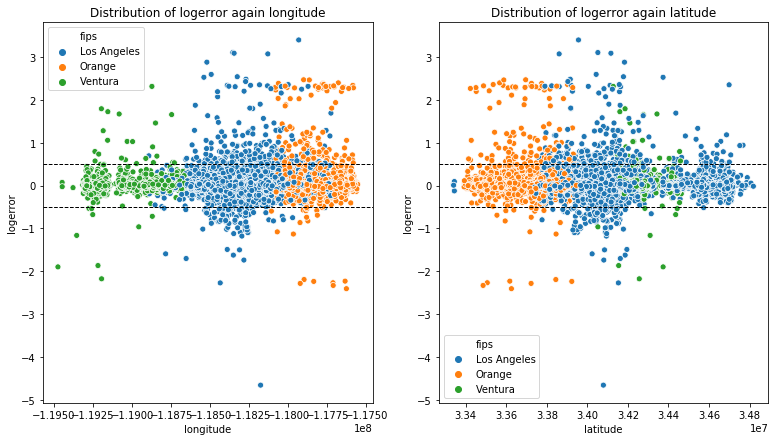

In [11]:
# Plot distribution of logerror again 
plt.figure(figsize=(13,7))

plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again longitude')

plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again latitude')

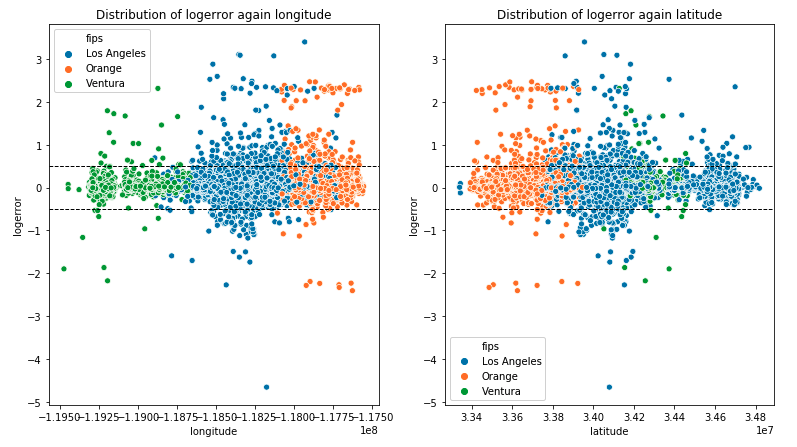

In [12]:
Image(filename = "logerror_long_lat.png", width = 750, height = 500)

## What if Clustering on logerror?

## What if Clustering on logerror?
- ### Group 1: logtaxvaluedollarcnt, logerror
- ### Group 2: taxvaluedollarcnt, logerror
- ### Group 3: (taxvaluedollarcnt, logerror), (latitude, longitute)
- ### Group 3: (taxvaluedollarcnt, logerror), (year)

In [13]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset
train, validate, test = wrangle_zillow.wrangle_zillow_clustering_2(zillow)

In [14]:
# Create a new varible: Log-transformed taxvaluedollarcnt

train['logtaxvaluedollarcnt'] = np.log10(train.taxvaluedollarcnt)
validate['logtaxvaluedollarcnt'] = np.log10(validate.taxvaluedollarcnt)
test['logtaxvaluedollarcnt'] = np.log10(test.taxvaluedollarcnt)

In [15]:
# Choose Group 1 to cluster on

cols_to_cluster = ['logtaxvaluedollarcnt', 'logerror']
train_g1 = train[cols_to_cluster]
validate_g1 = validate[cols_to_cluster]
test_g1 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g1_scaled, validate_g1_scaled, test_g1_scaled = prepare.standard_scaler(train_g1, 
                                                                                      validate_g1, 
                                                                                      test_g1)
scaler, train_g1_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 2))

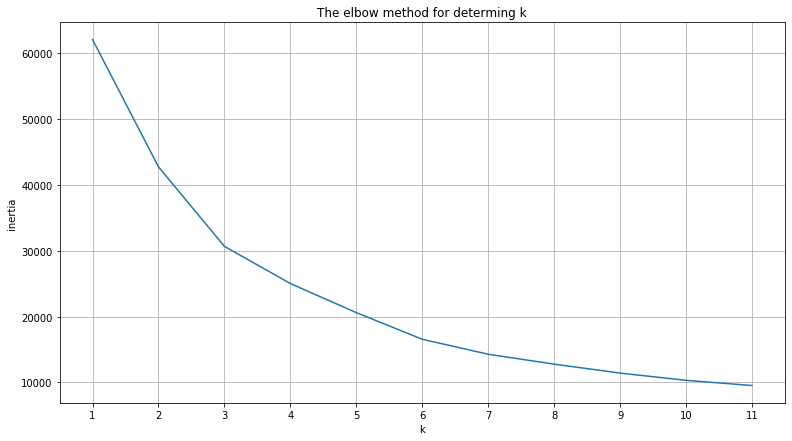

In [16]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g1_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [17]:
kmeans1, cluster1 = model.kmeans_labels(train_g1_scaled, cols_to_cluster, 6)
cluster1.head()

,cluster
71142,1
11459,1
54330,1
46830,0
53521,0


In [18]:
train = pd.concat([train, cluster1], axis=1)
train.rename(columns={'cluster': 'cluster1'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,1
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,1
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,1
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0


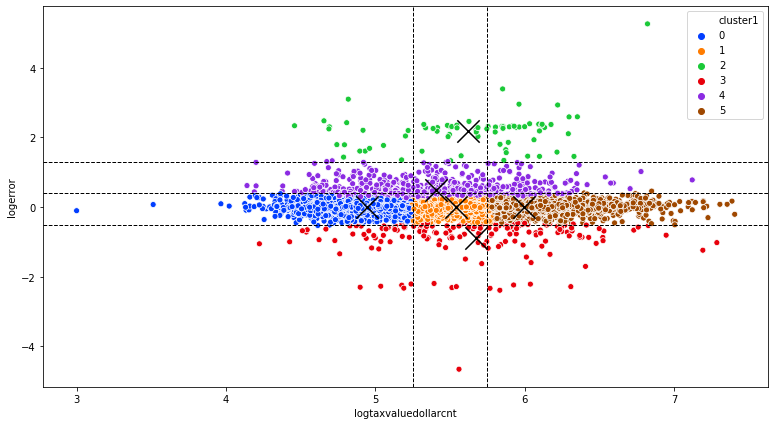

In [19]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster1', palette='bright')
plt.axhline(0.4, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(5.25, color='k', linestyle='dashed', linewidth=1)
plt.axvline(5.75, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster1').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')

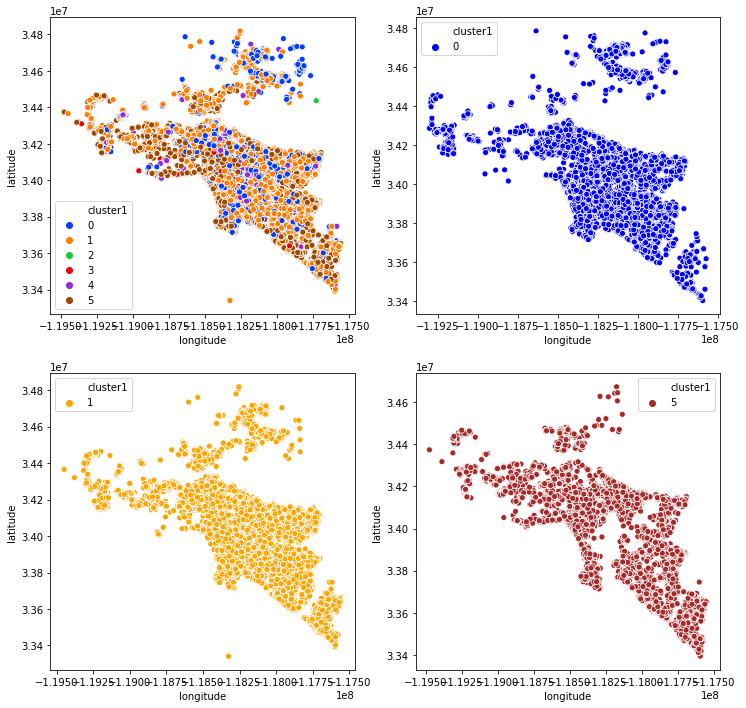

In [20]:
plt.figure(figsize=(12,12))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster1', palette='bright')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster1 == 0], 
                           x='longitude', y='latitude', hue='cluster1', palette=['blue'])

plt.subplot(223)
sns.scatterplot(data=train[train.cluster1 == 1], 
                           x='longitude', y='latitude', hue='cluster1', palette=['orange'])

plt.subplot(224)
sns.scatterplot(data=train[train.cluster1 == 5], 
                           x='longitude', y='latitude', hue='cluster1', palette=['brown'])

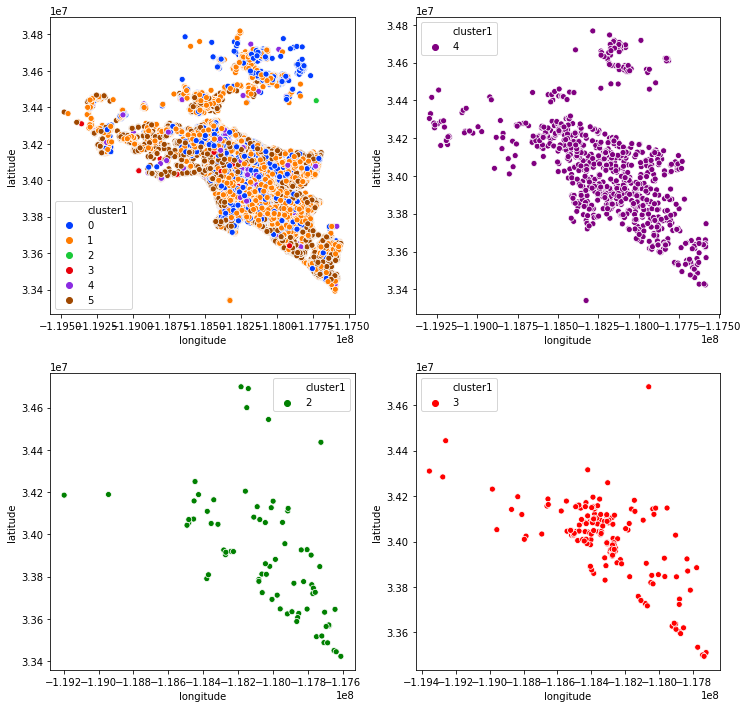

In [21]:
plt.figure(figsize=(12,12))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster1', palette='bright')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster1 == 4], 
                           x='longitude', y='latitude', hue='cluster1', palette=['purple'])

plt.subplot(223)
sns.scatterplot(data=train[train.cluster1 == 2], 
                           x='longitude', y='latitude', hue='cluster1', palette=['green'])

plt.subplot(224)
sns.scatterplot(data=train[train.cluster1 == 3], 
                           x='longitude', y='latitude', hue='cluster1', palette=['red'])

### Clustering Group 2: taxvaluedollarcnt, logerror

In [22]:
# Choose Group 2 to cluster on

cols_to_cluster = ['taxvaluedollarcnt', 'logerror']
train_g2 = train[cols_to_cluster]
validate_g2 = validate[cols_to_cluster]
test_g2 = test[cols_to_cluster]

# Scaled Group 1 by standard scaler
scaler, train_g2_scaled, validate_g2_scaled, test_g2_scaled = prepare.standard_scaler(train_g2, 
                                                                                      validate_g2, 
                                                                                      test_g2)
scaler, train_g2_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True), (31028, 2))

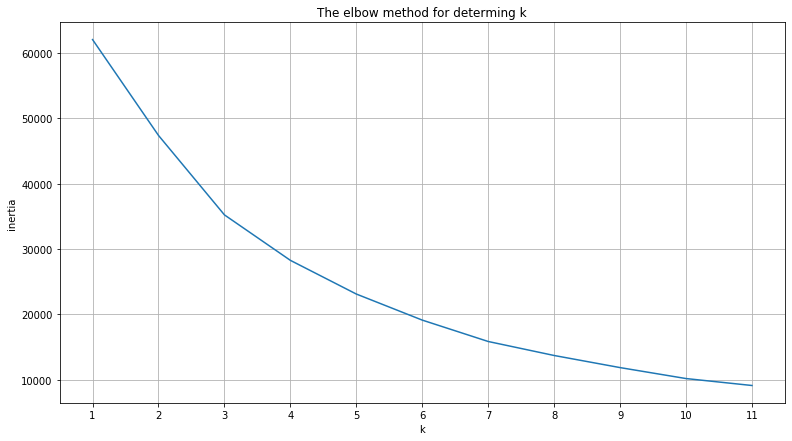

In [23]:
# Visualize Elbwo Method

output = {}

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_g2_scaled)
    output[k] = kmeans.inertia_

ax = pd.Series(output).plot(figsize=(13,7))
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='The elbow method for determing k')
ax.grid()

In [24]:
kmeans2, cluster2 = model.kmeans_labels(train_g2_scaled, cols_to_cluster, 6)
cluster2.head()

,cluster
71142,0
11459,0
54330,0
46830,0
53521,0


In [25]:
train = pd.concat([train, cluster2], axis=1)
train.rename(columns={'cluster': 'cluster2'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster1,cluster2
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,1,0
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,1,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,1,0
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0,0


Text(0.5, 1.0, 'Clustering target variable logerror')

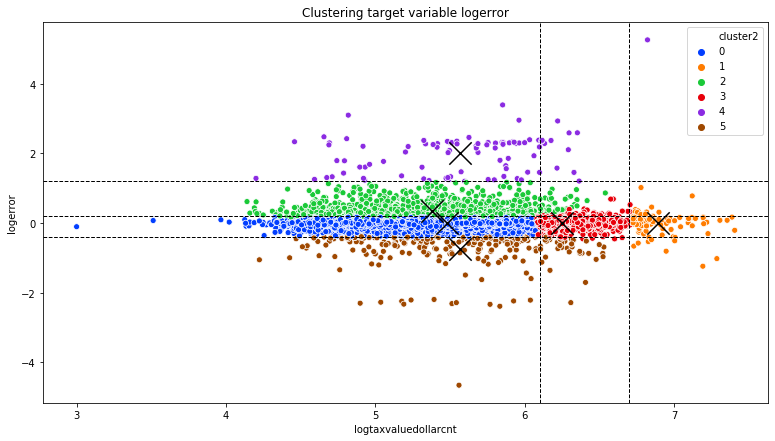

In [26]:
plt.figure(figsize=(13,7))

ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)
train.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')
plt.title('Clustering target variable logerror')

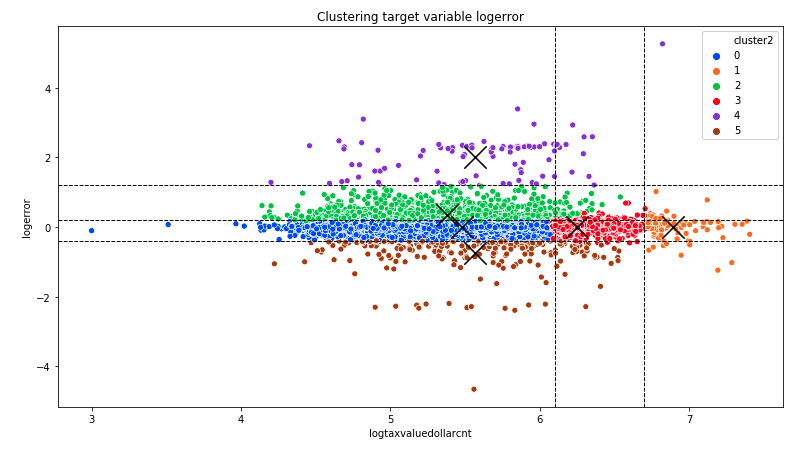

In [27]:
Image(filename = "clustering_logerror.png", width = 750, height = 500)

## Where are those properties with medium or high logerror?
### - Do they form clusters on the map? 

Text(0.5, 1.0, 'luxury')

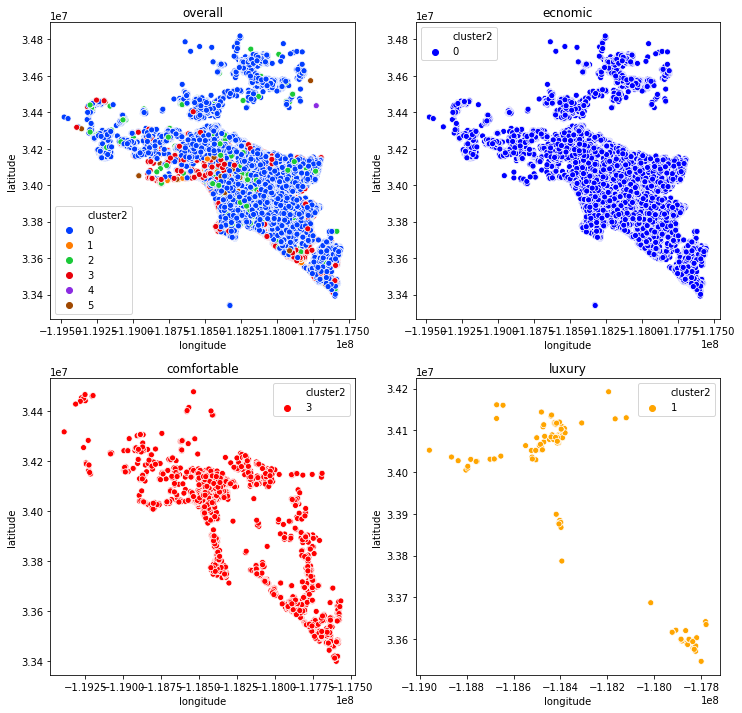

In [28]:
plt.figure(figsize=(12,12))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 0], 
                           x='longitude', y='latitude', hue='cluster2', palette=['blue'])
plt.title('ecnomic')

plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 3], 
                           x='longitude', y='latitude', hue='cluster2', palette=['red'])
plt.title('comfortable')

plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 1], 
                           x='longitude', y='latitude', hue='cluster2', palette=['orange'])
plt.title('luxury')

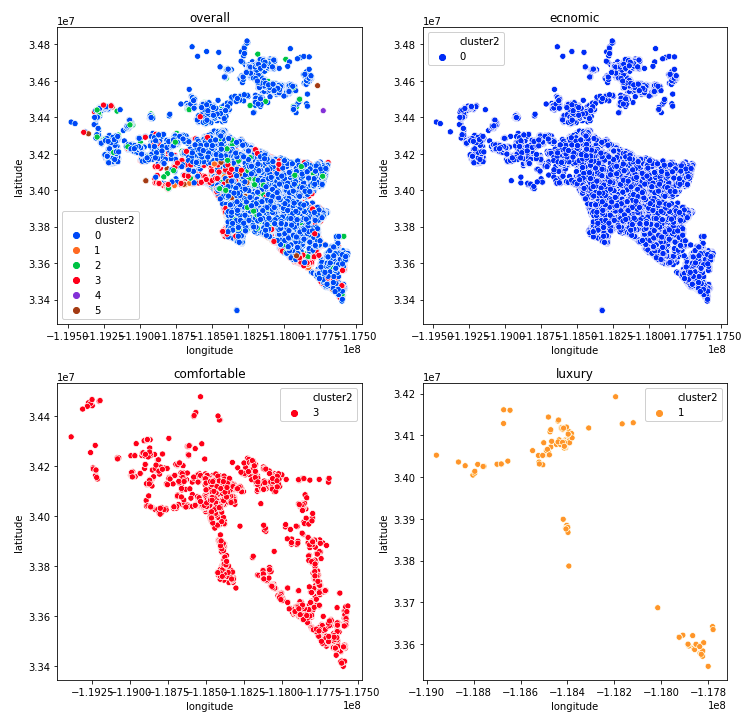

In [29]:
Image(filename = "cluster_geo_price.png", width = 750, height = 400)

Text(0.5, 1.0, 'error type: medium/high negative')

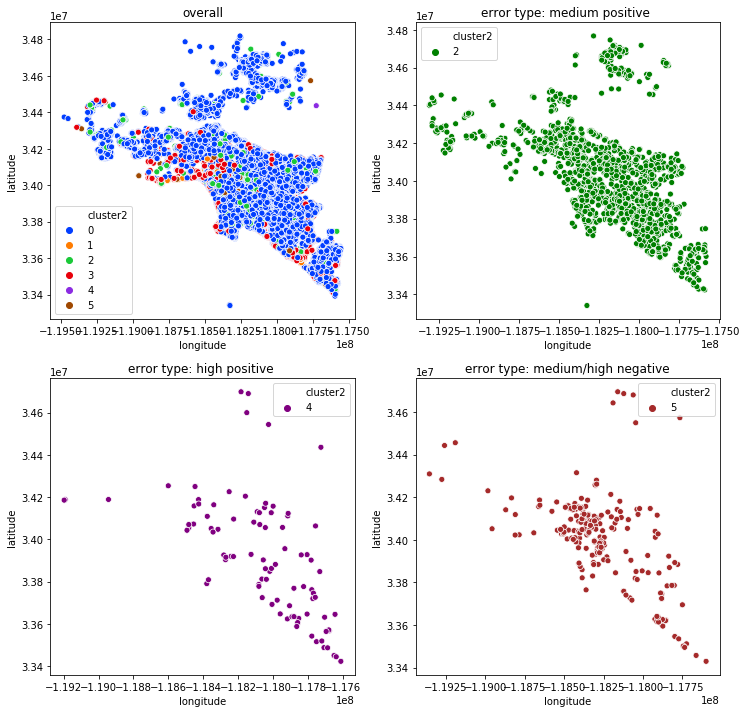

In [30]:
plt.figure(figsize=(12,12))

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 2], 
                           x='longitude', y='latitude', hue='cluster2', palette=['green'])
plt.title('error type: medium positive ')

plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 4], 
                           x='longitude', y='latitude', hue='cluster2', palette=['purple'])
plt.title('error type: high positive ')

plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 5], 
                           x='longitude', y='latitude', hue='cluster2', palette=['brown'])
plt.title('error type: medium/high negative')

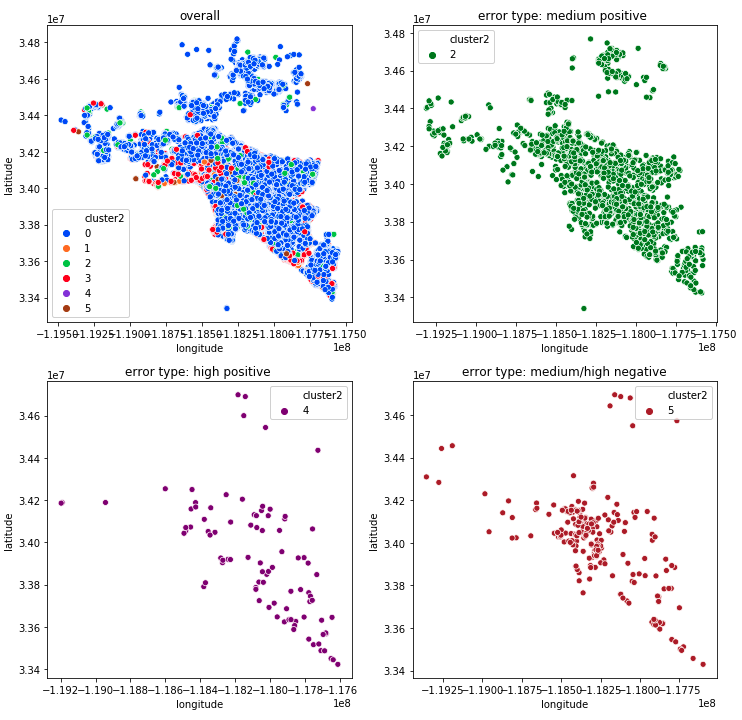

In [31]:
Image(filename = "cluster_geo_error.png", width = 750, height = 400)

## Conclusions:

### - The logerror is tends to increase as the property value drops.
### - The logerror can be clustered into 6 groups based on the property value and error range.
### - No specific clusters of medium/high positve logerror are found based on longitude and latitude.
### - Medium/high nagetive logerror has a obvious cluster in LA country. 

## Thanks for your attention. 
### - The modeling and evalutions are documented in my github repo. Welcome for discussion if you have further insterst. 

## Which group should I model on? 

## Scale train/validate/test by standardscaler

In [32]:
# Load train/validate/test datasets labled with at least cluster1-2 from csv

train = pd.read_csv('train.csv', index_col=0)
validate = pd.read_csv('validate.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

# Create masks for group 1 in cluster1 and group 0 in cluster2. 

# mask for train dataset
mask_tr_cluster1_1 = (train.cluster1 == 1)
mask_tr_cluster2_0 = (train.cluster2 == 0)

# mask for validate dataset
mask_v_cluster1_1 = (validate.cluster1 == 1)
mask_v_cluster2_0 = (validate.cluster2 == 0)

# mask for test dataset
mask_t_cluster1_1 = (test.cluster1 == 1)
mask_t_cluster2_0 = (test.cluster2 == 0)

# Create train/validate/test for group 1 in cluster1

train_cluster1_1 = train[mask_tr_cluster1_1]
validate_cluster1_1 = validate[mask_v_cluster1_1]
test_cluster1_1 = test[mask_t_cluster1_1]

# Create train/validate/test for group 0 in cluster2

train_cluster2_0 = train[mask_tr_cluster2_0]
validate_cluster2_0 = validate[mask_v_cluster2_0]
test_cluster2_0 = test[mask_t_cluster2_0]

# Create a variable to hold the numeric features be scaled, 16 in total. 

columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
                    'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
                    'latitude', 'longitude', 'lotsizesquarefeet',
                    'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
                    'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
                    'logtaxvaluedollarcnt']

# Scale train/validate/test for group 1 in cluster1

scaler, train_scaled_1_1, validate_scaled_1_1, test_scaled_1_1 = prepare.scale_standard(train_cluster1_1,
                                                                                        validate_cluster1_1,
                                                                                        test_cluster1_1,
                                                                                        columns_to_scale)
train_scaled_1_1.shape, validate_scaled_1_1.shape, test_scaled_1_1.shape

((15165, 24), (6386, 22), (3765, 22))

In [33]:
# Scale train/validate/test for group 2 in cluster0

scaler, train_scaled_2_0, validate_scaled_2_0, test_scaled_2_0 = prepare.scale_standard(train_cluster2_0,
                                                                                        validate_cluster2_0,
                                                                                        test_cluster2_0,
                                                                                        columns_to_scale)
scaler, train_scaled_2_0.shape, validate_scaled_2_0.shape, test_scaled_2_0.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (26841, 24),
 (11496, 22),
 (6798, 22))

## Feature Engineering on training dataset

In [34]:
# Show all the columns in training dataset, 19 in total

predictors=['error_type', 'fips_Orange', 'fips_Ventura',
            'bathroomcnt_scaled', 'bedroomcnt_scaled', 'buildingqualitytypeid_scaled',
            'calculatedfinishedsquarefeet_scaled', 'finishedsquarefeet12_scaled',
            'fullbathcnt_scaled', 'latitude_scaled', 'longitude_scaled',
            'lotsizesquarefeet_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
            'structuretaxvaluedollarcnt_scaled', 'taxvaluedollarcnt_scaled',
            'landtaxvaluedollarcnt_scaled', 'taxamount_scaled','logtaxvaluedollarcnt_scaled']

In [35]:
# Set the X and y for group 1 in cluster1

X_train_scaled_1_1 = train_scaled_1_1[predictors]
y_train_1_1 = train_scaled_1_1['logerror']

X_validate_scaled_1_1 = validate_scaled_1_1[predictors]
y_validate_1_1 = validate_scaled_1_1['logerror']

X_test_scaled_1_1 = test_scaled_1_1[predictors]
y_test_1_1 = test_scaled_1_1['logerror']

# Set the X and y for group 2 in cluster0

X_train_scaled_2_0 = train_scaled_2_0[predictors]
y_train_2_0 = train_scaled_2_0['logerror']

X_validate_scaled_2_0 = validate_scaled_2_0[predictors]
y_validate_2_0 = validate_scaled_2_0['logerror']

X_test_scaled_2_0 = test_scaled_2_0[predictors]
y_test_2_0 = test_scaled_2_0['logerror']

## Select top 10 features by select KBset

In [36]:
# Group 1 in cluster1

f_features_1_1 = features.select_kbest(X_train_scaled_1_1, y_train_1_1, 10)
f_features_1_1

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'landtaxvaluedollarcnt_scaled']

In [37]:
# Group 2 in cluster0

f_features_2_0 = features.select_kbest(X_train_scaled_2_0, y_train_2_0, 10)
f_features_2_0

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled']

## Select top 10 features by select KBset

In [38]:
rfe_features_1_1 = features.rfe(X_train_scaled_1_1, y_train_1_1, 10)
rfe_features_1_1

['error_type',
 'bathroomcnt_scaled',
 'buildingqualitytypeid_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

In [39]:
rfe_features_2_0 = features.rfe(X_train_scaled_2_0, y_train_2_0, 10)
rfe_features_2_0

['error_type',
 'fips_Ventura',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'latitude_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

## Modeling for Group 1 cluster 1

### Set up baseline

In [40]:
# Compute baseline prediction using mean

mean, median = y_train_1_1.agg(['mean', 'median'])

baseline = np.array([mean]*y_train_1_1.size)
baseline[:5], len(baseline)

(array([0.00195396, 0.00195396, 0.00195396, 0.00195396, 0.00195396]), 15165)

In [41]:
# Compute baseline sse

baseline_residual = y_train_1_1 - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

72.8356969472252

In [42]:
# Compute baseline mse

baseline_mse = baseline_sse/y_train_1_1.size
baseline_mse

0.0048028814340405675

In [43]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_1_1, baseline)**1/2
baseline_rmse

0.0024014407170202838

### Test 3 different algorithms for f_features and rfe_features
- LinearRegression
- LassoLars
- Poly(2nd degree)

In [44]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_1_1_f = X_train_scaled_1_1[f_features_1_1]
X_train_scaled_1_1_rfe = X_train_scaled_1_1[rfe_features_1_1]

### LinearRegression

In [45]:
# Create lm object

lm = LinearRegression(normalize=True)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [46]:
# Fit train dataset with f_features, predict and calculate the lm_rmse

lm_f = lm.fit(X_train_scaled_1_1_f, y_train_1_1)
lm_pred_f = lm_f.predict(X_train_scaled_1_1_f)
lm_rmse_f = mean_squared_error(y_train_1_1, lm_pred_f)**1/2

lm_rmse_f

0.0013638278316285659

In [47]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lm_rfe = lm.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lm_pred_rfe = lm_rfe.predict(X_train_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_train_1_1, lm_pred_rfe)**1/2

lm_rmse_rfe

0.001362398014085791

### LassoLars()

In [48]:
# Create lars object (alpha=0.1)

lars = LassoLars(alpha=0.1)
lars

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [49]:
# Fit train dataset with f_features, predict and calculate the rmse

lars_f = lars.fit(X_train_scaled_1_1_f, y_train_1_1)
lars_pred_f = lars_f.predict(X_train_scaled_1_1_f)
lars_rmse_f = mean_squared_error(y_train_1_1, lars_pred_f)**1/2

lars_rmse_f

0.0024014407170202838

In [50]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lars_rfe = lars.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lars_pred_rfe = lars_rfe.predict(X_train_scaled_1_1_rfe)
lars_rmse_rfe = mean_squared_error(y_train_1_1, lars_pred_rfe)**1/2

lars_rmse_rfe

0.0024014407170202838

### Poly(2nd Degree)

In [51]:
# Transform X_train_scaled_f and _rfe to squared.

pf2 = PolynomialFeatures(degree=2)
X_train_scaled_squared_f = pf2.fit_transform(X_train_scaled_1_1_f)
X_train_scaled_squared_rfe = pf2.fit_transform(X_train_scaled_1_1_rfe)

In [52]:
# Create lm_squared object

lm_squared2 = LinearRegression()

In [53]:
# Fit X_train_scaled_squared_f, predict and compute the rmse

lm_squared_f = lm_squared2.fit(X_train_scaled_squared_f, y_train_1_1)
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_train_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

0.001286513535963518

In [54]:
# Fit X_train_scaled_squared_rfe, predict and compute the rmse

lm_squared_rfe = lm_squared2.fit(X_train_scaled_squared_rfe, y_train_1_1)
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_train_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

0.0013232589698699358

In [55]:
# Summarize the RMSE of all 6 models

rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

rmse_train = pd.DataFrame(rmse_values, index=rmse_index, columns=['train_RMSE'])
rmse_train.sort_values(by='train_RMSE')

,train_RMSE
lm_squared_rmse_f,0.001287
lm_squared_rmse_rfe,0.001323
lm_rmse_rfe,0.001362
lm_rmse_f,0.001364
baseline_rmse,0.002401
lars_rmse_f,0.002401
lars_rmse_rfe,0.002401


### Validate top 3 models
### Poly(2nd) with both f_ and rfe_features

In [56]:
# Create X_validate_scaled for f_features and rfe_features

X_validate_scaled_1_1_f = X_validate_scaled_1_1[f_features_1_1]
X_validate_scaled_1_1_rfe = X_validate_scaled_1_1[rfe_features_1_1]

In [57]:
# Transform X_validate_scaled_f and _rfe to squared.

X_validate_scaled_squared_f = pf2.transform(X_validate_scaled_1_1_f)
X_validate_scaled_squared_rfe = pf2.transform(X_validate_scaled_1_1_rfe)

In [58]:
# Predict and compute the rmse

lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_validate_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

5.553328183871766e+20

In [59]:
# Predict and compute the rmse

lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_validate_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

2.359372893449051e+17

### LinearRegression with rfe features

In [60]:
# Predict and compute the rmse

lm_pred = lm.predict(X_validate_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_validate_1_1, lm_pred)**1/2

lm_rmse_rfe

0.0013295100424344794

In [61]:
rmse_values = [baseline_rmse,
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_rmse_rfe']

rmse_validate = pd.DataFrame(rmse_values, index=rmse_index, columns=['validate_RMSE'])
rmse_validate.sort_values(by='validate_RMSE')

,validate_RMSE
lm_rmse_rfe,1.329510e-03
baseline_rmse,2.401441e-03
lm_squared_rmse_rfe,2.359373e+17
lm_squared_rmse_f,5.553328e+20


### Test for the best model: LinearRegression with rfe features

In [62]:
# Create X_train_scaled for rfe_features

X_test_scaled_1_1_rfe = X_test_scaled_1_1[rfe_features_1_1]
X_test_scaled_1_1_f = X_test_scaled_1_1[f_features_1_1]

In [63]:
# Predict and compute the rmse

lm_pred = lm.predict(X_test_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_test_1_1, lm_pred)**1/2

lm_rmse_rfe

0.0013398546021102945

In [64]:
rmse_values = [baseline_rmse,lm_rmse_rfe]
rmse_index = ['baseline_rmse','lm_rmse_rfe']

rmse_test = pd.DataFrame(rmse_values, index=rmse_index, columns=['test_RMSE'])
rmse_test.sort_values(by='test_RMSE')

,test_RMSE
lm_rmse_rfe,0.001340
baseline_rmse,0.002401


In [65]:
rmse_overall = pd.concat([rmse_train, rmse_validate], axis=1)
rmse_overall = pd.concat([rmse_overall, rmse_test], axis=1)

rmse_overall.sort_values(by='train_RMSE')

,train_RMSE,validate_RMSE,test_RMSE
lm_squared_rmse_f,0.001287,5.553328e+20,NaN
lm_squared_rmse_rfe,0.001323,2.359373e+17,NaN
lm_rmse_rfe,0.001362,1.329510e-03,0.001340
lm_rmse_f,0.001364,NaN,NaN
baseline_rmse,0.002401,2.401441e-03,0.002401
lars_rmse_f,0.002401,NaN,NaN
lars_rmse_rfe,0.002401,NaN,NaN


## Takeaways from Modeling

## Discussion the reasons behind the best and worst model

Text(0.5, 1.0, 'Distribution of predicted y by the best model')

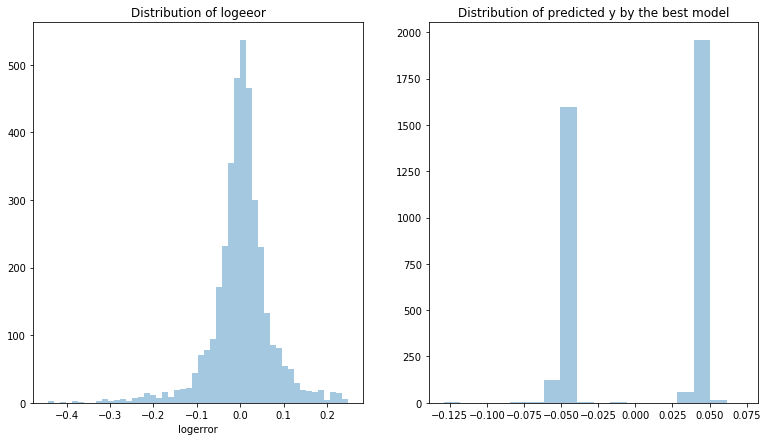

In [66]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.distplot(pd.Series(lm_pred), kde=False)
plt.title('Distribution of predicted y by the best model')

Text(0.5, 1.0, 'Distribution of predicted y by the worst model')

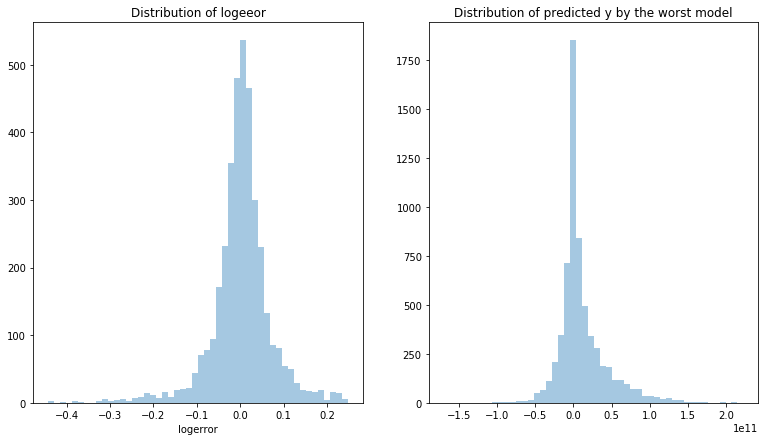

In [67]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.distplot(pd.Series(lm_squared_pred_f), kde=False)
plt.title('Distribution of predicted y by the worst model')

Text(0.5, 1.0, 'Distribution of predicted y by the worst model')

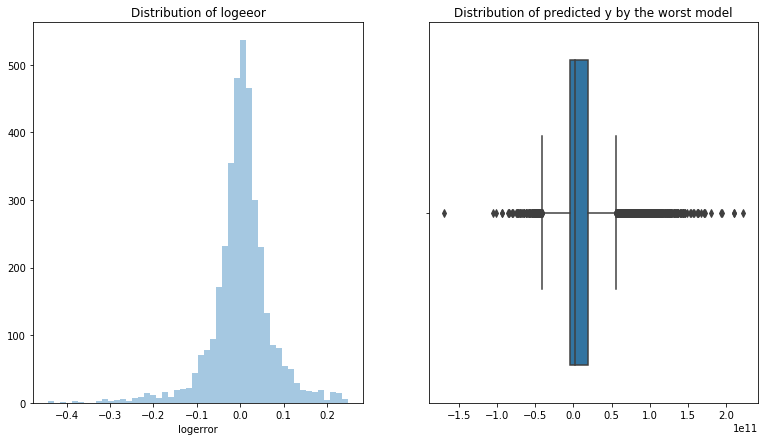

In [68]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.boxplot(pd.Series(lm_squared_pred_f))
plt.title('Distribution of predicted y by the worst model')